# Homework 3 - Luka Radić
## SCIPER: 354502

## Import the libraries needed

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from typing import Optional
from itertools import product

## Exercise 1: Backpropagation with logistic loss

We first define the `sigmoid` and `grad_sigmoid` functions that we will use throughout the exercise.

In [2]:
# Defining the constants used throughout the exercise
D = 5
K = 6

def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def grad_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

### Task 1: `predict` function

The `predict` function takes a batch of samples and the weights between input and hidden layers, as well as hidden and output layers, and returns a prediction in the interval $[0,1]$.

In [3]:
def predict(X,W):
    X_0 = X

    W_1 = W["w_1"]
    w_2 = W["w_2"]

    Z_1 = X_0 @ W_1
    X_1 = sigmoid(Z_1)
    z_2 = X_1 @ w_2
    y_hat = sigmoid(z_2)

    return Z_1, z_2, y_hat

### Task 2: `logistic_loss` function

In [4]:
def logistic_loss(y, y_hat):
    eps = 1e-12
    log_loss = -y.dot(np.log(y_hat+eps)) - (1-y).dot(np.log(1-y_hat+eps))
    return np.mean( log_loss )

In [5]:
B = 5 # esentially it can be anything, the result does not depend on it
y = np.zeros(B)
y_hat = np.zeros(B)
log_loss = logistic_loss(y, y_hat)
print("The average log-loss of the batch is {}".format(log_loss))

The average log-loss of the batch is -5.000444502909205e-12


When $y=0$ and $\hat{y}=0$, the logistic loss comes down to:
$$
\mathcal{L}(0,0) = 0 \log0 - 1 \log1 = 0 
$$
However, even though the first term is $0$ so we do not actually need to calculate $\log0$, python does so and it outputs an error because $\log0$ is undefined (goes to $-\infty$). This could also pose a problem when our prediction is very wrong i.e., when for instance $y=1$ and $\hat{y}=0$. We could add a small constant $\varepsilon=10^{-12}$ inside the $\log$s, but then the function output, even though it is small, is not exactly zero (as expected). For very low $\log$ arguments, small changes in the input produce large output changes, so the question of the optimal $\varepsilon$ value arises. We try to fix these problems by implementing a stable logistic loss. 

### Task 3: `stable_logistic_loss` function

Let us first derive the expression for logistic loss as a function of $z^{(2)}$.
$$
\begin{align*}
  \mathcal{L}(y,z^{(2)}) &= y \log\frac{1}{\hat{y}} + (1-y) \log \frac{1}{1-\hat{y}} \\
  &= y \log \left(1+e^{-z^{(2)}}\right) + (1-y)\log\left(\frac{1+e^{-z^{(2)}}}{e^{-z^{(2)}}}\right) \\
  &= y \log \left(1+e^{-z^{(2)}}\right) + (1-y)\log\left(1+e^{z^{(2)}}\right)
\end{align*}
$$

We then implement this as a stable logistic loss.

In [6]:
def stable_logistic_loss(y, z_2):
    log_loss = y.dot(np.logaddexp(0,-z_2)) + (1-y).dot(np.logaddexp(0,z_2))
    return np.mean( log_loss )

In [7]:
B = 5 # esentially it can be anything, the result does not depend on it
y = np.zeros(B)
z_2 = -1e10 * np.ones(B)
stable_log_loss = stable_logistic_loss(y, z_2)
print("The average stable-log-loss of the batch is {}".format(stable_log_loss))

The average stable-log-loss of the batch is 0.0


Why is this function stable? Well, let us look at the derivative of the standard logistic loss we implemented in *Task 2*, and for our current implementation. For the $batch\_size=1$ case, it can be shown that
$$
\frac{d \mathcal{L}(y,\hat{y})}{d \hat{y}} = \frac{\hat{y}-y}{\hat{y}(1-\hat{y})}
$$
$$
\frac{d \mathcal{L}_{stable}(y, z^{(2)})}{d z^{(2)}} = \hat{y} - y
$$
We see that the derivative of our stable implementation is much more robust to small perturbations, and its absolute value is at most 1, while the standard implementation from *Task 2* can reach very high values.

### Task 4: Analytical backpropagation

Let us denote with:
- $x_i^{(0)}$ the $i$-th component of the input vector
- $w_{ij}^{(1)}$ the weight of the edge connecting $x_i^{(0)}$ and the $j$-th node in the hidden layer $z_j^{(1)}$
- $w_j^{(2)}$ the weight of the edge connecting $z_j^{(1)}$ and the output node $z^{(2)}$
- $\hat{y}$ the final prediction

where $i=\overline{1,D},\; j=\overline{1,K}$. Note that the inputs of activation functions for each node in the NN can be calculated as:
$$
z_j^{(1)} = \sum_{i=1}^D \; w_{ij}^{(1)} x_i^{(0)}, \quad z^{(2)} = \sum_{j=1}^K \; w_j^{(2)} \sigma\left(z_j^{(1)}\right)
$$
We use the stable implementation of logistic loss:
$$
\mathcal{L}(x,y,w) = y \log\left( 1 + e^{-z^{(2)}} \right) + (1-y) \log\left( 1 + e^{z^{(2)}} \right)
$$

We first find the partial derivatives of *hidden-output* weights:
$$
\begin{align*}
    \frac{\partial \mathcal{L}(x,y,w)}{\partial w_j^{(2)}} &= - y \frac{e^{-z^{(2)}}}{1 + e^{-z^{(2)}}} \frac{\partial z^{(2)}}{\partial w_j^{(2)}} + (1-y) \frac{e^{z^{(2)}}}{1 + e^{z^{(2)}}} \frac{\partial z^{(2)}}{\partial w_j^{(2)}} \\
    &= \left[ - y \frac{e^{-z^{(2)}}}{1 + e^{-z^{(2)}}} + (1-y) \frac{e^{z^{(2)}}}{1 + e^{z^{(2)}}} \right] \; \sigma\left(z_j^{(1)}\right)
\end{align*}
$$

Now we find the partial derivatives of *input-hidden* weights. For that purpose, it is useful to rewrite $z^{(2)}$ as:
$$
z^{(2)} = \sum_{j=1}^K \; w_j^{(2)} \sigma\left(z_j^{(1)}\right) = \sum_{j=1}^K \; w_j^{(2)} \sigma\left(\sum_{i=1}^D \; w_{ij}^{(1)} x_i^{(0)}\right)
$$

$$
\begin{align*}
    \frac{\partial \mathcal{L}(x,y,w)}{\partial w_{ij}^{(1)}} &= \left[ - y \frac{e^{-z^{(2)}}}{1 + e^{-z^{(2)}}} + (1-y) \frac{e^{z^{(2)}}}{1 + e^{z^{(2)}}} \right] \frac{\partial z^{(2)}}{\partial w_{ij}^{(1)}} \\
    &= \left[ - y \frac{e^{-z^{(2)}}}{1 + e^{-z^{(2)}}} + (1-y) \frac{e^{z^{(2)}}}{1 + e^{z^{(2)}}} \right] \; w_j^{(2)} \sigma'\left(\sum_{i=1}^D \; w_{ij}^{(1)} x_i^{(0)}\right) x_i^{(0)}
\end{align*}
$$

Considering that
$$
\frac{d\sigma(x)}{dx} = \frac{e^{-x}}{(1+e^{-x})^2} = \frac{1}{1+e^{-x}} \left(\frac{1+e^{-x}}{1+e^{-x}}-\frac{1}{1+e^{-x}}\right) = \sigma(x)\left[1-\sigma(x)\right]
$$
we can finally write the partial derivative as
$$
    \frac{\partial \mathcal{L}(x,y,w)}{\partial w_{ij}^{(1)}} = \left[ - y \frac{e^{-z^{(2)}}}{1 + e^{-z^{(2)}}} + (1-y) \frac{e^{z^{(2)}}}{1 + e^{z^{(2)}}} \right] \; w_j^{(2)} \sigma\left(z_j^{(1)}\right)\left[1-\sigma\left(z_j^{(1)}\right)\right] x_i^{(0)}
$$

### Task 5: `gradient` function

Following the formulas derived above, we implement the `gradient` function, but keeping in mind that it is computed w.r.t the batch, not a signle sample.

In [8]:
def gradient(X, y, W):
    B = X.shape[0]
    # Feedforward
    Z_1, z_2, y_hat = predict(X, W)
    X_1 = sigmoid(Z_1)
    # Backpropagation
    delta_2 = -y * np.exp(-z_2)/(1+np.exp(-z_2)) + (1-y)*np.exp(z_2)/(1+np.exp(z_2))
    delta_w_2 = delta_2.reshape(-1,1) * X_1
    delta_w_2_mean = np.mean(delta_w_2, axis=0)
    delta_1 = delta_2.reshape(-1,1) * grad_sigmoid(Z_1) * W["w_2"]
    delta_w_1_mean = 1/B * X.T @ delta_1
    
    return {
        "w_1": delta_w_1_mean,
        "w_2": delta_w_2_mean
    }

## Exercise 2: Classifying `FashionMNIST` using neural networks

### Task 1: Loading data

We load the train and test datasets. For our new train and validation sets, we take random subsets of the original training set, 50000 and 10000 images each. Since the images are in the PIL format, we need to convert them to tensors using `ToTensor()` transformation.

In [12]:
IMAGE_SIZE = 28*28

# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" 
transform = T.Compose([
    T.ToTensor()
])

# Load the training dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# Make a validation dataset by splitting the original training one
train_dataset,  valid_dataset = random_split(
    train_dataset, 
    lengths=[50000, 10000], 
    generator=torch.Generator().manual_seed(456)
)

# Load the test dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

Our datasets are quite large, so we cannot update them on a sample basis. Thus, we will train them in *batches*, which means that the model weights are updated only after a predefined number of samples have been "feed-forwarded". For that purpose, we construct dataloaders - wrappers for our train/test datasets.

In [13]:
# Define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01

# Find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# construct the dataloader for the traininig dataset. 
# Here we shuffle the data to promote stochasticity.
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

# Construct the dataloader for the testing dataset.
test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

cuda


Let us visualize some of the samples.

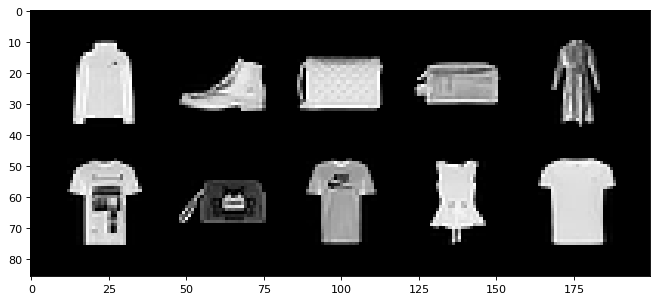

In [14]:
# Get the first 10 images of the train dataset. Hint: use next(), iter()
images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(10,8), dpi=80)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

### Task 2: MultiLayer Perceptron (MLP)

Now we define our MLP architecture with two hidden layers of 100 neurons each. Not that the `ReLU` is defined twice - for each hidden layer. Although ReLU is not layer-specific and without learnable parameters, meaning that it is always calling into a stateless function `max(0, x)`, some problems have been reported when using unique ReLU realization for every layer.

In [15]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # first hidden layer
    self.fc1 =  nn.Linear(IMAGE_SIZE, 100)
    self.relu1 = nn.ReLU()
    # second hidden layer
    self.fc2 = nn.Linear(100, 100)
    self.relu2 = nn.ReLU()
    # output layer; we have 10 classes
    self.fc3 = nn.Linear(100, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    batch_size = x.shape[0]
    # flattening the images
    x = x.view(batch_size, -1)

    # forwardpass
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    x = self.relu2(x)
    x = self.fc3(x)
    
    return x

We now define the functons `train_epoch` which contains the training logic during one training epoch.

In [16]:
def train_epoch(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    device: torch.device
    ):
    '''
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    '''

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # do the forward pass
        output = model(data)
        # compute the loss
        loss = F.cross_entropy(output, target)
        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
    
    return running_loss / len(train_dataloader.dataset)

Next, we define the `predict` method, which evaluates how well our trained model performs on the test set. It is also used during training with cross-validation on the validation dataset to detect overfitting.

In [17]:
def predict(model: nn.Module, test_dataloader: DataLoader, device: torch.device, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)#, reduction="sum")
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100.0 * correct / len(test_dataloader.dataset)

    if verbose:
        print(
            f"Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)"
        )

    return test_loss, accuracy

Finally, we define the `fit` method, which contains all the logic for full model training with the possibility of cross-validation.

In [18]:
def fit(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    epochs: int, 
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a 
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model, 
            train_dataloader=train_dataloader, 
            optimizer=optimizer, 
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

    return train_losses, valid_losses, valid_accs

After we have defined all the training and evaluation "machinery", we can finally start the training process. We define the number of epochs and four different types of optimizers we want to test. Let us briefly explain the hyperparameters and the optimization algorithms we use:

- **learning rate** $\eta$ dictates the magnitude by which the weights shift in the direction of the gradient. Large $\eta$ leads to making huge steps, so there is a risk of jumping across the minimum or oscillating around it. On the other hand, low $\eta$ makes convergence slower, can lead to getting stuck on flat objective areas or local minima instead of global.

- **momentum** $m$ is a term we add to the update rule to take into account the previous update history. For example, there is a non-negligible chance that the previous gradient direction was good, and if the current gradient approximation is noisy, the momentum term "keeps us on track". It also solves the oscillations encountered when reaching the minimum. This hyperparameter defines how much weight do we want to add to the gradient history.

- **Stochastic Gradient Descent (SGD)** is an optimization method that takes a random sample and updates the weights based only on it, rather than computing the gradients for the whole dataset and only then applying the update. This can lead to noisy estimation, so adding a momentum term should help in mitigating this effect.

- **Adaptive Moment Estimation (ADAM)** is an optimization method that updates the learning rate parameter-wise. It does so by keeping track of the exponentially decaying average of both the gradients (boiling down to the momentum) and the square of the gradients.

In [19]:
EPOCHS = 20

models = [Net(), Net(), Net(), Net()]
for model in models:
  model.to(DEVICE)

optimizers = []
optimizers.append(optim.SGD(models[0].parameters(), lr=0.01))
optimizers.append(optim.SGD(models[1].parameters(), lr=0.01, momentum=0.9, nesterov=True))
optimizers.append(optim.Adam(models[2].parameters(), lr=0.01))
optimizers.append(optim.Adam(models[3].parameters(), lr=1))

names = [
    'Optimizer: SGD, lr=0.01',
    'Optimizer: SGD, lr=0.01, momentum=0.9',
    'Optimizer: Adam, lr=0.01',
    'Optimizer: Adam, lr=1'
]

We train our four MLP models.

In [20]:
train_losses_models_MLP = {}
valid_losses_models_MLP = {}

for i in range(len(models)):
  model = models[i]
  optimizer = optimizers[i]

  train_losses, valid_losses, valid_accs = fit(
        model=model, 
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        optimizer=optimizer,
        epochs=EPOCHS,
        device=DEVICE
    )
  
  train_losses_models_MLP[i] = train_losses
  valid_losses_models_MLP[i] = valid_losses

  print(f"%"*100)
  print(f"Trial [{names[i]}]: Validation accuracy = {valid_accs[-1]:.4f}")
  print(f"%"*100)

Epoch 0: Train Loss=0.0022, Validation Loss=0.0023, Validation acc=22.7900
Epoch 1: Train Loss=0.0022, Validation Loss=0.0022, Validation acc=30.4100
Epoch 2: Train Loss=0.0021, Validation Loss=0.0021, Validation acc=37.4000
Epoch 3: Train Loss=0.0020, Validation Loss=0.0020, Validation acc=42.8300
Epoch 4: Train Loss=0.0019, Validation Loss=0.0018, Validation acc=48.4900
Epoch 5: Train Loss=0.0017, Validation Loss=0.0016, Validation acc=58.7200
Epoch 6: Train Loss=0.0015, Validation Loss=0.0015, Validation acc=59.7300
Epoch 7: Train Loss=0.0014, Validation Loss=0.0013, Validation acc=61.0900
Epoch 8: Train Loss=0.0012, Validation Loss=0.0012, Validation acc=62.6700
Epoch 9: Train Loss=0.0012, Validation Loss=0.0012, Validation acc=63.4300
Epoch 10: Train Loss=0.0011, Validation Loss=0.0011, Validation acc=63.7200
Epoch 11: Train Loss=0.0010, Validation Loss=0.0010, Validation acc=64.7000
Epoch 12: Train Loss=0.0010, Validation Loss=0.0010, Validation acc=65.6600
Epoch 13: Train Loss=0

SGD without momentum has an accuracy of around 70% which is not that great, but when we add an additional momentum term, it jumps significantly to 85%, proving the positive effects the previous gradient history has. ADAM with initial $\eta=0.01$ works best with an accuracy of around 89%, but when the initial $\eta=1$ is too big, the adaptation cannot follow the tempo of gradient changes.

Further, we get the predictions for the test set, and get the expected results.

In [21]:
for model in models:
  predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0008, Accuracy: 6859/10000 (69%)
Test set: Avg. loss: 0.0005, Accuracy: 8368/10000 (84%)
Test set: Avg. loss: 0.0004, Accuracy: 8782/10000 (88%)
Test set: Avg. loss: 0.0023, Accuracy: 1000/10000 (10%)


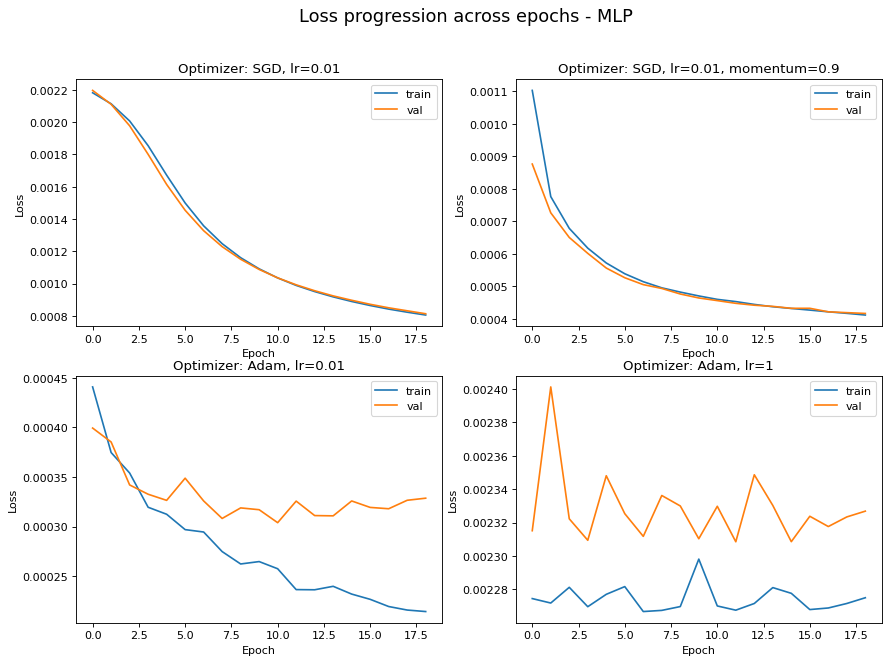

In [70]:
fig = plt.figure(figsize=(13,9), dpi=80)
plt.suptitle('Loss progression across epochs - MLP', fontsize=16)

for i in range(len(models)):
  plt.subplot(2,2,i+1)
  plt.title(names[i])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(train_losses_models_MLP[i][1:], label='train')
  plt.plot(valid_losses_models_MLP[i][1:], label='val')
  plt.legend(fontsize=10)

When using SGD optimizers, train and validation loss curves almost coincide and decrease, which indicates that overfitting still did not emerge hence we could increase the number of training epochs to get better results.

The ADAM $\eta=0.01$ optimizer curves really depict its power, where a small number of epochs is enough to learn the parameters. Further training basically yields no improvement in results, and can potentially lead to overfitting. However, the ADAM $\eta=1$ plots show that the train loss (which is of no significance for our evaluation) is very good, while on the validation set it does not perform very well.

### Task 3: Convolutional Neural Network (CNN)

We first create a CNN model.

In [23]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )

    # Fully connected output layer
    self.out = nn.Linear(576, 10)

  def forward(self, x):
    # propagate through convolutional layers
    x = self.conv(x)
    # flattening the "convolutional" output
    x = x.view(x.size(0), -1)
    # propagate through FC layer
    x = self.out(x)

    return x


We repeat the same training procedure as with the MLP. We set the number of epochs to 20 and test on four different optimizers.

In [24]:
EPOCHS = 20

models = [CNN(), CNN(), CNN(), CNN()]
for model in models:
  model.to(DEVICE)

optimizers = []
optimizers.append(optim.SGD(models[0].parameters(), lr=0.01))
optimizers.append(optim.SGD(models[1].parameters(), lr=0.01, momentum=0.9, nesterov=True))
optimizers.append(optim.Adam(models[2].parameters(), lr=0.01))
optimizers.append(optim.Adam(models[3].parameters(), lr=1))

names = [
    'Optimizer: SGD, lr=0.01',
    'Optimizer: SGD, lr=0.01, momentum=0.9',
    'Optimizer: Adam, lr=0.01',
    'Optimizer: Adam, lr=1'
]

In [25]:
train_losses_models_CNN = {}
valid_losses_models_CNN = {}

for i in range(len(models)):
  model = models[i]
  optimizer = optimizers[i]

  train_losses, valid_losses, valid_accs = fit(
        model=model, 
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        optimizer=optimizer,
        epochs=EPOCHS,
        device=DEVICE
    )
  
  train_losses_models_CNN[i] = train_losses
  valid_losses_models_CNN[i] = valid_losses

  print(f"%"*100)
  print(f"Trial [{names[i]}]: Validation accuracy = {valid_accs[-1]:.4f}")
  print(f"%"*100)

Epoch 0: Train Loss=0.0023, Validation Loss=0.0023, Validation acc=14.4000
Epoch 1: Train Loss=0.0022, Validation Loss=0.0023, Validation acc=12.9600
Epoch 2: Train Loss=0.0022, Validation Loss=0.0023, Validation acc=18.2400
Epoch 3: Train Loss=0.0022, Validation Loss=0.0023, Validation acc=19.5700
Epoch 4: Train Loss=0.0022, Validation Loss=0.0022, Validation acc=20.7900
Epoch 5: Train Loss=0.0022, Validation Loss=0.0022, Validation acc=26.8400
Epoch 6: Train Loss=0.0021, Validation Loss=0.0020, Validation acc=44.9000
Epoch 7: Train Loss=0.0018, Validation Loss=0.0016, Validation acc=58.6600
Epoch 8: Train Loss=0.0013, Validation Loss=0.0011, Validation acc=60.9400
Epoch 9: Train Loss=0.0011, Validation Loss=0.0011, Validation acc=63.3000
Epoch 10: Train Loss=0.0010, Validation Loss=0.0009, Validation acc=65.1100
Epoch 11: Train Loss=0.0010, Validation Loss=0.0010, Validation acc=67.6300
Epoch 12: Train Loss=0.0009, Validation Loss=0.0009, Validation acc=65.7900
Epoch 13: Train Loss=0

Compared to the MLP, the CNN models performed 2-4% better for all optimizers, except for ADAM $\eta=1$, where there were no improvements. This was expected, since the CNNs are designed to work with images and take advantage of their local information (more on that in *Task 4*).

Again, the test predictions match the expectations.

In [26]:
for model in models:
  predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0008, Accuracy: 7172/10000 (72%)
Test set: Avg. loss: 0.0004, Accuracy: 8471/10000 (85%)
Test set: Avg. loss: 0.0003, Accuracy: 9065/10000 (91%)
Test set: Avg. loss: 0.0023, Accuracy: 1000/10000 (10%)


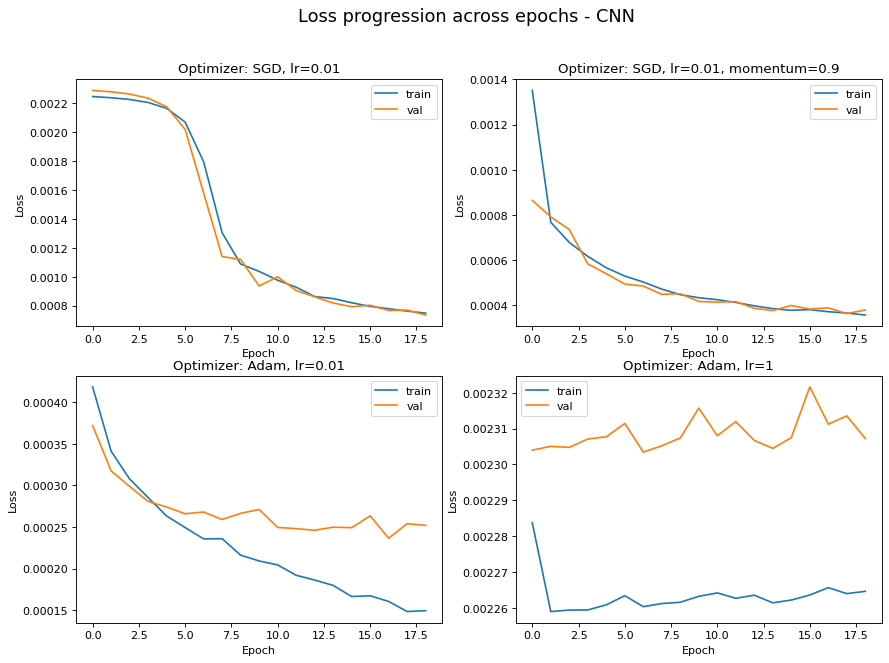

In [71]:
fig = plt.figure(figsize=(13,9), dpi=80)
plt.suptitle('Loss progression across epochs - CNN', fontsize=16)

for i in range(len(models)):
  plt.subplot(2,2,i+1)
  plt.title(names[i])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(train_losses_models_CNN[i][1:], label='train')
  plt.plot(valid_losses_models_CNN[i][1:], label='val')
  plt.legend(fontsize=10)

Again, as with the MLP models, the SGD curves indicate that the number of epochs could be increased. We now see that the validation curves are a bit noisy, but that effect is negligible. The conclusions we made for the ADAM optimizers before hold here as well.

### Task 4: Number of model parameters

We define a function `num_parameters` that returns a number of all parameters for a given model, including the non-trainable ones (note that our MLP and CNN models do not have non-trainable parameters).

In [28]:
def num_parameters(model: nn.Module) -> int:
  return sum(
      param.numel() for param in model.parameters()
  )

We calculate the number of parameters our MLP and CNN models have.

In [29]:
mlp = Net()
cnn = CNN()
num_mlp = num_parameters(mlp)
num_cnn = num_parameters(cnn)

print(f"Number of parameters in the MLP model: {num_mlp}")
print(f"Number of parameters in the CNN model: {num_cnn}")

Number of parameters in the MLP model: 89610
Number of parameters in the CNN model: 29066


The number of CNN parameters is 3 times lower than the MLP case but our previous analysis shows that, despite this, the CNN performed better. Thus we conclude that having more parameters does not translate to better performance. But why is this the case?

CNNs are designed specifically to work with images, where neighboring pixels are expected to be highly correlated, while distant pixels have high probability of being "independent". The kernel convolution is defined to aggregate the local information of a pixel, so not all the inputs in the layer affect the outputs of the next layer. On the contrary, when working with images, fully connected networks first flatten them and then connect all the inputs to all the output nodes. Not only do the FC networks have more parameters (weights), but since the natural order of the image is lost, they perform worse than the CNNs.

### Task 5: Classification with `PermutedFashionMNIST`

We define a `RandomPermutation` transformation which randomly redistributes pixels in an image.

In [30]:
class RandomPermutation(object):
    def __init__(self, num_features):
        self.num_features = num_features
        self.reindex = torch.randperm(num_features)
    
    def __call__(self, img):
        assert self.num_features == img.numel()
        orig_shape = img.shape
        img = img.view(-1)[self.reindex].view(orig_shape)
        return img

We load the data as in *Task 1*, but now we add our `RandomPermutation` to the list of transformations.

In [31]:
IMAGE_SIZE = 28*28

# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" 
transform = T.Compose([
    T.ToTensor(),
    RandomPermutation(IMAGE_SIZE)
])

# Load the training dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# Make a validation dataset by splitting the original training one
train_dataset,  valid_dataset = random_split(
    train_dataset, 
    lengths=[50000, 10000], 
    generator=torch.Generator().manual_seed(456)
)

# Load the test dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

Again, we construct the dataloaders and define the batch sizes.

In [32]:
# Define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024

# Find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# construct the dataloader for the traininig dataset. 
# Here we shuffle the data to promote stochasticity.
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

# Construct the dataloader for the testing dataset.
test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

cuda


Let us visualize a few samples to make sure the pixels were indeed permuted.

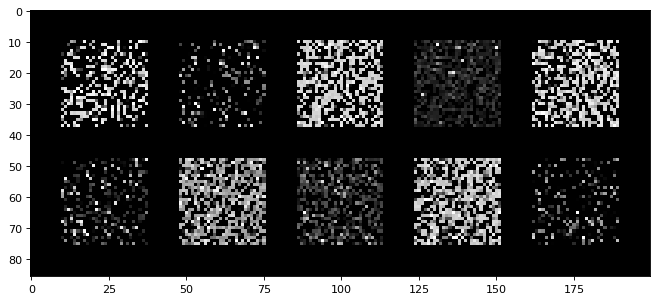

In [33]:
# Get the first 10 images of the train dataset. Hint: use next(), iter()
images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(10,8), dpi=80)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

Now, we define the hyperparameters and initialize the MLP/CNN models and optimizers.

In [34]:
LEARNING_RATE = 0.01
MOMENTUM = 0.9
EPOCHS = 20

# Find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

model_mlp = Net().to(DEVICE)
model_cnn = CNN().to(DEVICE)

optimizer_mlp = optim.SGD(model_mlp.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)

cuda


The next step is training both models.

In [35]:
# Training the MLP model
print(f"%"*100)
print(f"Training the MLP model")
print(f"%"*100)
train_losses_mlp, valid_losses_mlp, valid_accs_mlp = fit(
        model=model_mlp, 
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        optimizer=optimizer_mlp,
        epochs=EPOCHS,
        device=DEVICE
    )

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Training the MLP model
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Epoch 0: Train Loss=0.0020, Validation Loss=0.0016, Validation acc=55.1400
Epoch 1: Train Loss=0.0011, Validation Loss=0.0009, Validation acc=66.4700
Epoch 2: Train Loss=0.0008, Validation Loss=0.0007, Validation acc=72.5900
Epoch 3: Train Loss=0.0007, Validation Loss=0.0007, Validation acc=76.3400
Epoch 4: Train Loss=0.0006, Validation Loss=0.0006, Validation acc=79.1500
Epoch 5: Train Loss=0.0006, Validation Loss=0.0006, Validation acc=80.3400
Epoch 6: Train Loss=0.0005, Validation Loss=0.0005, Validation acc=81.4000
Epoch 7: Train Loss=0.0005, Validation Loss=0.0005, Validation acc=82.4300
Epoch 8: Train Loss=0.0005, Validation Loss=0.0005, Validation acc=82.9600
Epoch 9: Train Loss=0.0005, Validation Loss=0.0005, Validation acc=83.1600
Epoch 10: Train Loss=0.00

In [36]:
# Training the CNN model
print(f"%"*100)
print(f"Training the CNN model")
print(f"%"*100)
train_losses_cnn, valid_losses_cnn, valid_accs_cnn = fit(
        model=model_cnn, 
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        optimizer=optimizer_cnn,
        epochs=EPOCHS,
        device=DEVICE
    )

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Training the CNN model
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Epoch 0: Train Loss=0.0022, Validation Loss=0.0023, Validation acc=12.2000
Epoch 1: Train Loss=0.0021, Validation Loss=0.0019, Validation acc=39.0200
Epoch 2: Train Loss=0.0017, Validation Loss=0.0013, Validation acc=61.0500
Epoch 3: Train Loss=0.0011, Validation Loss=0.0009, Validation acc=69.5400
Epoch 4: Train Loss=0.0009, Validation Loss=0.0009, Validation acc=68.2900
Epoch 5: Train Loss=0.0008, Validation Loss=0.0007, Validation acc=74.2400
Epoch 6: Train Loss=0.0007, Validation Loss=0.0007, Validation acc=74.9400
Epoch 7: Train Loss=0.0007, Validation Loss=0.0006, Validation acc=77.3100
Epoch 8: Train Loss=0.0006, Validation Loss=0.0006, Validation acc=77.6900
Epoch 9: Train Loss=0.0006, Validation Loss=0.0006, Validation acc=78.2900
Epoch 10: Train Loss=0.00

Even though the differences are not major, we see that the CNN validation loss is higher than the MLP one, and that the accuracy is about 2% lower. As is said before, the MLP does not care about the pixel order in the image, instead the image is provided to the network flattened. Therefore, as expected, the metrics here are the same as the MLP metrics of *Task 2* (accuracy $\approx 85\%$). On the other hand, since CNN kernels capture local information, the CNN model performs worse when compared to the one in *Task 3* due to the random pixel permutations removing these information.

We predict the test set labels and calculate the corresponding metrics.

In [37]:
print('Predictions using the MLP: ')
predict(model=model_mlp, test_dataloader=test_dataloader, device=DEVICE)

print('Predictions using the CNN: ')
predict(model=model_cnn, test_dataloader=test_dataloader, device=DEVICE)

Predictions using the MLP: 
Test set: Avg. loss: 0.0004, Accuracy: 8408/10000 (84%)
Predictions using the CNN: 
Test set: Avg. loss: 0.0005, Accuracy: 8101/10000 (81%)


(0.0005277682393789292, tensor(81.0100, device='cuda:0'))

Now we plot the train/val curves for both models.

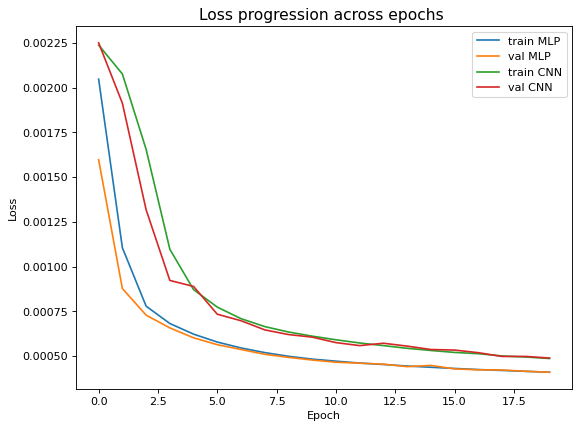

In [38]:
fig = plt.figure(figsize=(8,6), dpi=80)
plt.title('Loss progression across epochs ', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_losses_mlp, label='train MLP')
plt.plot(valid_losses_mlp, label='val MLP')
plt.plot(train_losses_cnn, label='train CNN')
plt.plot(valid_losses_cnn, label='val CNN')
plt.legend(fontsize=10)

For both models, the train/val curves coincide, which might mean that, if we increased the number of epochs, we would get better performance.

### Task 6 (*Bonus*): Grid search



In this task, we try to do a grid parameter search to find the optimal hyperparameters for our MLP and CNN models. We iterate over two values for learning rate and two values for batch size. We use SGD optimizer with momentum. Of course, we could also iterate for example over different optimizers or momentum values, but that would make the execution time quite long.Therefore, we need to constrain ourselves.

In [39]:
LR_GRID = [0.01, 0.1]
BS_GRID = [256, 512]

grid = list(product(LR_GRID, BS_GRID))

max_acc = 0
for index, (lr, bs) in enumerate(grid):

    train_dataloader = DataLoader(
        dataset=train_dataset, 
        batch_size=bs,
        shuffle=True, 
        num_workers=2)

    mlp = Net().to(DEVICE)

    optimizer_mlp = optim.SGD(mlp.parameters(), lr=lr, momentum=0.9, nesterov=True)

    train_losses, valid_losses, valid_accs = fit(
        model=mlp, 
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        optimizer=optimizer_mlp,
        epochs=20,
        device=DEVICE
    )

    print(f"%"*100)
    print(f"MLP: Trial {index}[lr={lr}, bs={bs}]: Validation accuracy = {valid_accs[-1]:.4f}")
    print(f"%"*100)

    if valid_accs[-1] > max_acc:
      max_acc = valid_accs[-1]
      final_mlp = mlp

Epoch 0: Train Loss=0.0047, Validation Loss=0.0007, Validation acc=76.0200
Epoch 1: Train Loss=0.0023, Validation Loss=0.0005, Validation acc=81.5200
Epoch 2: Train Loss=0.0020, Validation Loss=0.0005, Validation acc=82.2900
Epoch 3: Train Loss=0.0018, Validation Loss=0.0005, Validation acc=83.5300
Epoch 4: Train Loss=0.0017, Validation Loss=0.0004, Validation acc=84.0000
Epoch 5: Train Loss=0.0017, Validation Loss=0.0004, Validation acc=85.2700
Epoch 6: Train Loss=0.0016, Validation Loss=0.0004, Validation acc=85.9700
Epoch 7: Train Loss=0.0015, Validation Loss=0.0004, Validation acc=86.4900
Epoch 8: Train Loss=0.0015, Validation Loss=0.0004, Validation acc=86.7300
Epoch 9: Train Loss=0.0015, Validation Loss=0.0004, Validation acc=86.7400
Epoch 10: Train Loss=0.0014, Validation Loss=0.0004, Validation acc=86.8900
Epoch 11: Train Loss=0.0014, Validation Loss=0.0004, Validation acc=86.5000
Epoch 12: Train Loss=0.0014, Validation Loss=0.0004, Validation acc=86.4700
Epoch 13: Train Loss=0

We succeeded in improving the accuracy of our MLP model from *Task 2* which used SGD with momentum optimizer. Its accuracy was around 85%, while the MLP model with $\eta=0.1$ and $batch\_size=256$ achieved an accuracy of around 89%.

In [40]:
print("Best MLP model")
predict(model=final_mlp, test_dataloader=test_dataloader, device=DEVICE)

Best MLP model
Test set: Avg. loss: 0.0004, Accuracy: 8809/10000 (88%)


(0.00035376969873905184, tensor(88.0900, device='cuda:0'))

In [41]:
LR_GRID = [0.01, 0.1]
BS_GRID = [256, 512]

grid = list(product(LR_GRID, BS_GRID))

max_acc = 0
for index, (lr, bs) in enumerate(grid):

    train_dataloader = DataLoader(
        dataset=train_dataset, 
        batch_size=bs,
        shuffle=True, 
        num_workers=2)

    cnn = CNN().to(DEVICE)

    optimizer_cnn = optim.SGD(cnn.parameters(), lr=lr, momentum=0.9, nesterov=True)

    train_losses, valid_losses, valid_accs = fit(
        model=cnn, 
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        optimizer=optimizer_cnn,
        epochs=20,
        device=DEVICE
    )

    print(f"%"*100)
    print(f"CNN: Trial {index}[lr={lr}, bs={bs}]: Validation accuracy = {valid_accs[-1]:.4f}")
    print(f"%"*100)

    if valid_accs[-1] > max_acc:
      max_acc = valid_accs[-1]
      final_cnn = cnn

Epoch 0: Train Loss=0.0074, Validation Loss=0.0014, Validation acc=53.2400
Epoch 1: Train Loss=0.0033, Validation Loss=0.0007, Validation acc=73.5900
Epoch 2: Train Loss=0.0024, Validation Loss=0.0006, Validation acc=80.5300
Epoch 3: Train Loss=0.0021, Validation Loss=0.0005, Validation acc=81.6900
Epoch 4: Train Loss=0.0019, Validation Loss=0.0005, Validation acc=83.2500
Epoch 5: Train Loss=0.0018, Validation Loss=0.0004, Validation acc=84.3000
Epoch 6: Train Loss=0.0017, Validation Loss=0.0005, Validation acc=83.2500
Epoch 7: Train Loss=0.0017, Validation Loss=0.0004, Validation acc=85.5700
Epoch 8: Train Loss=0.0016, Validation Loss=0.0004, Validation acc=85.4900
Epoch 9: Train Loss=0.0015, Validation Loss=0.0004, Validation acc=85.6600
Epoch 10: Train Loss=0.0015, Validation Loss=0.0004, Validation acc=86.1100
Epoch 11: Train Loss=0.0014, Validation Loss=0.0004, Validation acc=85.3200
Epoch 12: Train Loss=0.0014, Validation Loss=0.0004, Validation acc=86.9300
Epoch 13: Train Loss=0

Compared to the *Task 3* CNN model using SGD with momentum (where accuracy was 86%), we only increased the accuracy by 1%, by using the same $\eta=0.01$ and reducing the batch size from 1024 to 256.

In [42]:
print("Best CNN model")
predict(model=final_cnn, test_dataloader=test_dataloader, device=DEVICE)

Best CNN model
Test set: Avg. loss: 0.0004, Accuracy: 8598/10000 (86%)


(0.00038585223555564883, tensor(85.9800, device='cuda:0'))

## Exercise 3: Multi-Task Learning with `MultiMNIST`

### Task 1: Function `make_new_sample`

This function takes as input two images represented as tensors of shape `(num_channels, height, width)` ($28\times28$) and outputs a new $36\times36$ image as a combination of the two. Note that we introduce the first dimension of `num_channels=1`, because it is the image representation `PyTorch` works with. The number of channels is 1 since all images in the `MNIST` dataset are grayscale.

In [43]:
def make_new_sample(x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
  res = torch.zeros((1,36,36))
  res[0, :28, :28] = x1
  res[0, 8:, 8:] = torch.maximum(res[0, 8:, 8:], x2)
  return res

### Task 2: Creating the `MultiMNIST` dataset

As we did many times until now, we load the train and test `MNIST` datasets.

In [44]:
TRAIN_SIZE = 60000
TEST_SIZE = 10000

# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" 
transform = T.Compose([
    T.ToTensor()
])

train_mnist = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

test_mnist = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

Here we create lists of new multi-image-samples and labels, which we will later parse to the `MultiMNIST` dataset instances. The main idea is to create a $60000\times2$ and $10000\times2$ matrices for train and test sets respectively. The values are randomly generated indices of images in the original `MNIST` train/test sets, and their rows represent two images that we are going to merge and use as a sample for our new `MultiMNIST` dataset. 

In [45]:
train_indices = np.random.randint(low=0, high=TRAIN_SIZE, size=(TRAIN_SIZE,2))
test_indices = np.random.randint(low=0, high=TEST_SIZE, size=(TEST_SIZE,2))

# Creating training samples and labels
train_multimnist_samples = []
train_multimnist_label1 = []
train_multimnist_label2 = []
for i in range(TRAIN_SIZE):
  img1 = train_indices[i][0]
  img2 = train_indices[i][1]
  multi_image = make_new_sample(train_mnist[img1][0][0], train_mnist[img2][0][0])
  train_multimnist_samples.append(multi_image)
  train_multimnist_label1.append(train_mnist[img1][1])
  train_multimnist_label2.append(train_mnist[img2][1])

# Creating test samples and labels
test_multimnist_samples = []
test_multimnist_label1 = []
test_multimnist_label2 = []
for i in range(TEST_SIZE):
  img1 = test_indices[i][0]
  img2 = test_indices[i][1]
  multi_image = make_new_sample(test_mnist[img1][0][0], test_mnist[img2][0][0])
  test_multimnist_samples.append(multi_image)
  test_multimnist_label1.append(test_mnist[img1][1])
  test_multimnist_label2.append(test_mnist[img2][1])

Now we create a `MultiMNIST` class that inherits `PyTorch`'s `Dataset` class - a wrapper for our new dataset. We need to define two functions that are implicitly used when iterating through the sets:

- `__len__()`: the length (number of samples) of the dataset
- `__getitem__(idx)`: returns the sample at index `idx`

In [46]:
class MultiMNIST(Dataset):
  def __init__(self, samples, label1, label2):
    self.samples = samples
    self.label1 = label1
    self.label2 = label2

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    return self.samples[idx], self.label1[idx], self.label2[idx]

Further, we create the instances of train and test sets. As before, we will have a validation set to evaluate the performance during training phase.

In [47]:
train_dataset = MultiMNIST(train_multimnist_samples, train_multimnist_label1, train_multimnist_label2)

train_dataset,  valid_dataset = random_split(
    train_dataset, 
    lengths=[50000, 10000], 
    generator=torch.Generator().manual_seed(456)
)

test_dataset = MultiMNIST(test_multimnist_samples, test_multimnist_label1, test_multimnist_label2)

We define batch sizes and create dataloaders for each set.


In [48]:
# Define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024

# Find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# construct the dataloader for the traininig dataset. 
# Here we shuffle the data to promote stochasticity.
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

# Construct the dataloader for the testing dataset.
test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

cuda


Let us visualize a few of our new samples.

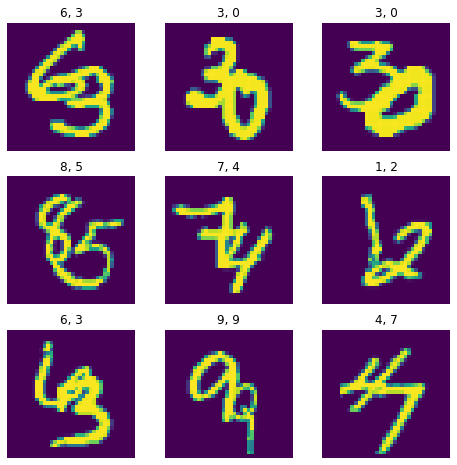

In [49]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label1, label2 = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{label1}, {label2}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="viridis")
plt.show()

### Task 3: Creating the Multi-Task model

It is now time to create the proper model architecture for Multi-Task learning. Our `forward` function returns two 10-sized outputs - one for each decoder.

In [50]:
class MultiTaskModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.linear = nn.Linear(1620,50)
    self.out1 = nn.Linear(50,10)
    self.out2 = nn.Linear(50,10)

  def forward(self, x):
    # propagate through convolutional layers
    x = self.conv(x)
    # flattening the "convolutional" output
    x = x.view(x.size(0), -1)
    # propagate through FC layer
    x = self.linear(x)

    # decode first image
    x1 = self.out1(x)
    # decode second image
    x2 = self.out2(x)

    return x1, x2

### Task 4: Training the Multi-Task model

We modify the `train_epoch` function so it can handle two losses. First, when we iterate through the dataset, we now get two different targets. When we run the model, we get two different outputs. Finall loss is computed as a mean of task losses.

In [51]:
def train_epoch_multi(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    device: torch.device
    ):
    '''
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    '''

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target1, target2) in enumerate(train_dataloader):
        # move data and targets to device
        data, target1, target2 = data.to(device), target1.to(device), target2.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # do the forward pass
        output1, output2 = model(data)
        # compute the losses and average them
        loss1, loss2 = F.cross_entropy(output1, target1), F.cross_entropy(output2, target2)
        loss = (loss1 + loss2) / 2

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
    
    return running_loss / len(train_dataloader.dataset)

We also have to modify the `predict` function. In addition to the loss computation described above, we also change the accuracy implementation. When calculating the number of correct classifications, we distinguish between three cases:

- +0: None of the two digits from the image are correctly classified
- +1: One of the two digits are correctly classified
- +2: Both digits are correctly classified

In order to calculate the accuracy, we need to divide the number of correctly classified digits by twice the length of the dataset, since we have twice as many digits than images.

In [52]:
def predict_multi(model: nn.Module, test_dataloader: DataLoader, device: torch.device, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target1, target2 in test_dataloader:
            data, target1, target2 = data.to(device), target1.to(device), target2.to(device)
            output1, output2 = model(data)
            loss1, loss2 = F.cross_entropy(output1, target1), F.cross_entropy(output2, target2)
            loss = (loss1 + loss2) / 2
            test_loss += loss.item()
            pred1 = output1.data.max(1, keepdim=True)[1]
            pred2 = output2.data.max(1, keepdim=True)[1]
            # the correct classifications are now digit-wise
            correct += pred1.eq(target1.data.view_as(pred1)).sum() + pred2.eq(target2.data.view_as(pred2)).sum()

    test_loss /= len(test_dataloader.dataset)
    # divide by 2*len(test_set)
    accuracy = 100.0 * correct / (len(test_dataloader.dataset)*2)

    if verbose:
        print(
            f"Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{2*len(test_dataloader.dataset)} ({accuracy:.0f}%)"
        )

    return test_loss, accuracy

Instead of `predict`, the `fit_multi` function now calls `predict_multi` function.

In [53]:
def fit_multi(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    epochs: int, 
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a 
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        train_loss = train_epoch_multi(
            model=model, 
            train_dataloader=train_dataloader, 
            optimizer=optimizer, 
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            # a call to predict_multi instead of predict
            valid_loss, valid_acc = predict_multi(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

    return train_losses, valid_losses, valid_accs

We define the hyperparameters, initialize our model and define the optimizer.

In [54]:
LEARNING_RATE = 0.01
MOMENTUM = 0.9
EPOCHS = 20

# Find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

model_mtm = MultiTaskModel()

optimizer_mtm = optim.SGD(model_mtm.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)

cuda


It is time for training!

In [55]:
# Training the MultiTask model
print(f"%"*100)
print(f"Training the MultiTask model")
print(f"%"*100)
train_losses_mtm, valid_losses_mtm, valid_accs_mtm = fit_multi(
        model=model_mtm, 
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        optimizer=optimizer_mtm,
        epochs=EPOCHS,
        device=DEVICE
    )

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Training the MultiTask model
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Epoch 0: Train Loss=0.0022, Validation Loss=0.0022, Validation acc=33.6050
Epoch 1: Train Loss=0.0018, Validation Loss=0.0015, Validation acc=53.1550
Epoch 2: Train Loss=0.0007, Validation Loss=0.0005, Validation acc=84.5100
Epoch 3: Train Loss=0.0004, Validation Loss=0.0004, Validation acc=87.3100
Epoch 4: Train Loss=0.0004, Validation Loss=0.0003, Validation acc=89.5650
Epoch 5: Train Loss=0.0003, Validation Loss=0.0003, Validation acc=90.6400
Epoch 6: Train Loss=0.0003, Validation Loss=0.0003, Validation acc=91.8000
Epoch 7: Train Loss=0.0002, Validation Loss=0.0002, Validation acc=92.6450
Epoch 8: Train Loss=0.0002, Validation Loss=0.0002, Validation acc=93.2950
Epoch 9: Train Loss=0.0002, Validation Loss=0.0002, Validation acc=93.7950
Epoch 10: Train Los

Our model performs very well, with an accuracy of 96%. 

In [56]:
print('Predictions using the MultiTask model: ')
predict_multi(model=model_mtm, test_dataloader=test_dataloader, device=DEVICE)

Predictions using the MultiTask model: 
Test set: Avg. loss: 0.0001, Accuracy: 19218/20000 (96%)


(0.00012198365703225136, tensor(96.0900, device='cuda:0'))

The performance on the test set lives up to the expectations we got from the validation metrics.

Finally, we plot the train/val curves.

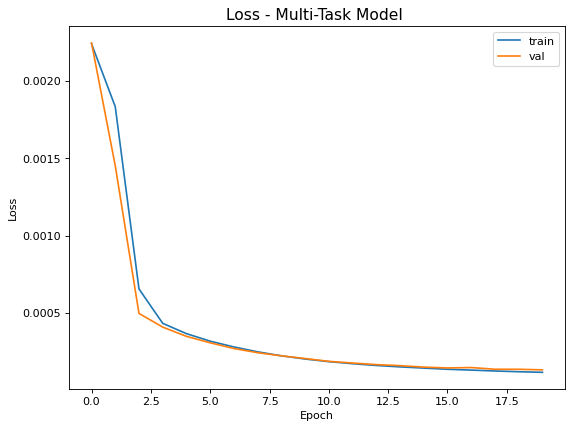

In [57]:
fig = plt.figure(figsize=(8,6), dpi=80)
plt.title('Loss - Multi-Task Model ', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_losses_mtm, label='train')
plt.plot(valid_losses_mtm, label='val')
plt.legend(fontsize=10)

We see that the train/val curves match, hence overfitting did not occur. They monotonically decrease, and increasing the number of epochs would probably yield slightly better results.